In [1]:
options(warn = -2)

###On télécharge les libraries utiles
library(dplyr, quietly = TRUE, , warn.conflicts = FALSE)
library(ggplot2, quietly = TRUE, warn.conflicts = FALSE)
library(tidyr, quietly = TRUE, warn.conflicts = FALSE)
library(rstatix, quietly = TRUE, warn.conflicts = FALSE)
library(car, quietly = TRUE, warn.conflicts = FALSE)
library(lmtest, quietly = TRUE, warn.conflicts = FALSE)
library(forecast, quietly = TRUE, warn.conflicts = FALSE)
library(infer, quietly = TRUE, warn.conflicts = FALSE)
library(caschrono, quietly = TRUE, warn.conflicts = FALSE)
library(reshape2, quietly = TRUE, warn.conflicts = FALSE )

select<-dplyr::select
filter<-dplyr::filter

setwd("C:/Users/Bruno/Desktop/ouvrablesFormations/P9_pinos_bruno")



Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


In [2]:
###fonction########################################################

###On crée une fonction pour analyser les regressions linéaires
f_graph<- function(fit,p){

df_function<-fit$model  
alpha <- 0.05
n <- dim(df_function)[1]
analyses <- data.frame(obs= 1:n)
analyses$levier <- hat(model.matrix(fit))
seuil_levier <- 2*p/n

analyses$rstudent <- rstudent(fit)
seuil_rstudent <- qt(1-alpha/2,n-p-1)

influence <- influence.measures(fit)
names(influence)
colnames(influence$infmat)

analyses$dcook <- influence$infmat[,"cook.d"]
seuil_dcook <- 4/(n-p)

layout(matrix(1:4, 2, 2))


return(
  list(
   plot(fit),
    
    ggplot(data.frame(fit$residuals),aes(fit.residuals)) + 
 geom_histogram(aes(y=..count..), colour="blue", fill= "white")+
  geom_vline(aes(xintercept=mean(fit.residuals), color="red"))+
  xlab("Residuals values")+ ylab("Number of residuals"),
    
ggplot(data=analyses,aes(x=obs, y=levier))+
   geom_bar(stat="identity",colour="steelblue")+
   geom_hline(yintercept=seuil_levier,col="red")+
   theme_minimal()+
   xlab("Observation")+
   ylab("Leviers")+
   scale_x_continuous(breaks=seq(0,n,by=5)),

ggplot(data=analyses,aes(x=obs,y=rstudent))+
  geom_bar(stat="identity",colour="steelblue")+
  geom_hline(yintercept=-seuil_rstudent,col="red")+
  geom_hline(yintercept=seuil_rstudent,col="red")+
  theme_minimal()+
  xlab("observation")+
  ylab("Résidus studentisés")+
  scale_x_continuous(breaks=seq(0,n,by=5)),

summary(fit),

bptest(fit),

vif(fit),

shapiro.test(fit$residuals),

ks.test(fit$residuals, "pnorm")
)
)
}

########################################################################

Date,Consommation
2012-01,51086
2012-02,54476
2012-03,43156
2012-04,40176
2012-05,35257
2012-06,33219


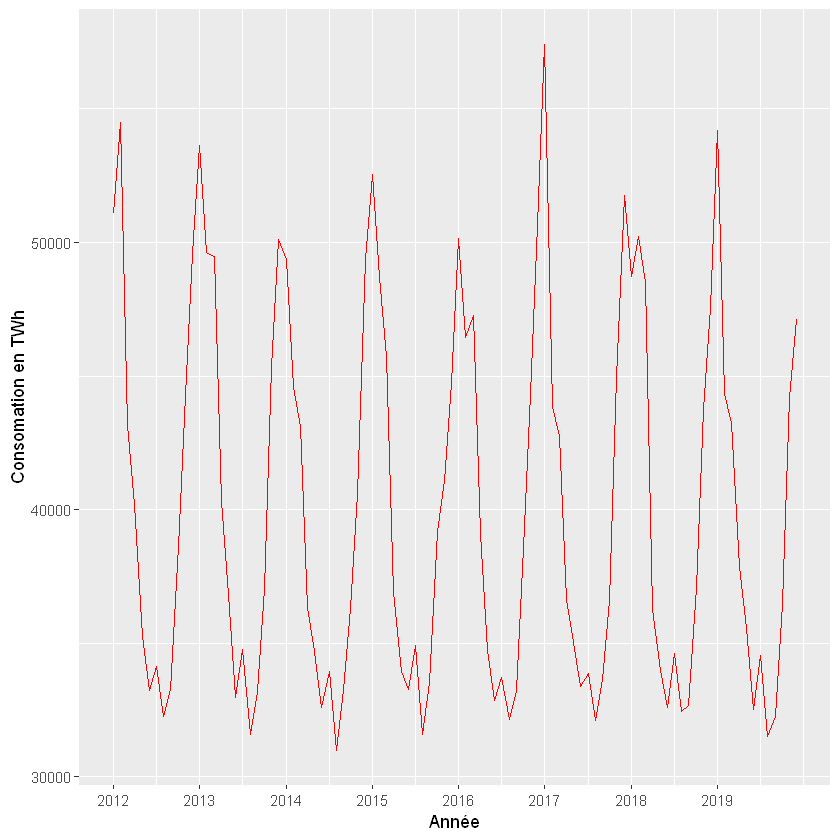

In [3]:
###On récupère les données de consomation
energie<-read.csv("energie.csv", sep = ",", encoding = "latin1")

###Je transforme la colonne mois en vecteur pour pouvoir les ordonner
energie$Mois<-energie$Mois%>%unlist()%>%as.vector()

#L'année 2020 comporte des données douteuses on les enlève
conso<-energie%>%
  filter(Territoire == "France" & Mois < "2020-01")%>%
  select(Date = Mois, Territoire, "Qualité", Conso = Consommation.totale)

#Je crée une colonne time qui est une clé primaire et qui me permettra
#d'étudier et de représenter la série temporelle 
conso$time<-1:nrow(conso)

#J'affiche le début des colonnes data et conso de ma table
head(select(conso, Date, Consommation = Conso))

x<-select(conso, Date, Consommation = Conso)
#Je construit le graph de ma série temporelle(conso en fct de année)
ggplot(conso, aes(x = time, y = Conso)) + 
  geom_path(col = "red")+ 
  scale_x_continuous(breaks=seq(1,96,12),
                   labels = c("2012","2013","2014","2015","2016","2017",
                              "2018","2019")) + xlab("Année")+
                    ylab("Consomation en TWh")

In [4]:
#Je récupère les données DJU de paris(~France)
DJU<-read.csv("DJU.csv", sep = ",", encoding = "latin1",
              skip = 11)%>%rename("Année" = X)



#Je rajoute les données DJU à ma table principale
for (j in 0:7) {
for (i in 1:12) {
  conso$DJU[i+j*12]<-DJU[9-j,i+1]
}
}

#Je crée une indicatrice mois dans ma table principale
for (i in 1:12){
  su=rep(0,times=12)
  su[i]=1
  s=rep(su,times=8)
  assign(paste("s",i,sep=""),s)
}

conso_lm<-cbind(conso,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12)

head(conso_lm%>%select(-"Territoire", -"Qualité"))

Date,Conso,time,DJU,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12
2012-01,51086,1,336.0,1,0,0,0,0,0,0,0,0,0,0,0
2012-02,54476,2,435.9,0,1,0,0,0,0,0,0,0,0,0,0
2012-03,43156,3,210.5,0,0,1,0,0,0,0,0,0,0,0,0
2012-04,40176,4,231.2,0,0,0,1,0,0,0,0,0,0,0,0
2012-05,35257,5,93.8,0,0,0,0,1,0,0,0,0,0,0,0
2012-06,33219,6,50.4,0,0,0,0,0,1,0,0,0,0,0,0


In [5]:
#je crée un modèle prédictif pour expliquer la consomation 
#à partir des mois de la DJU et du temps écoulé.
fit<-lm(Conso ~ time + s1 + s2 + s3 +s4 + s5 + s6 +
          s7 + s8 + s9 + s10 + s11 + s12 - 1 + DJU, conso_lm)

#j'analyse le modèle
summary(fit)


Call:
lm(formula = Conso ~ time + s1 + s2 + s3 + s4 + s5 + s6 + s7 + 
    s8 + s9 + s10 + s11 + s12 - 1 + DJU, data = conso_lm)

Residuals:
    Min      1Q  Median      3Q     Max 
-1626.9  -521.5  -115.2   488.1  2838.0 

Coefficients:
      Estimate Std. Error t value Pr(>|t|)    
time    -1.493      2.972  -0.502    0.617    
s1   35813.991    906.167  39.523   <2e-16 ***
s2   32735.317    846.452  38.674   <2e-16 ***
s3   33709.936    691.500  48.749   <2e-16 ***
s4   30151.066    523.577  57.587   <2e-16 ***
s5   30399.377    405.760  74.920   <2e-16 ***
s6   31373.101    330.086  95.045   <2e-16 ***
s7   33773.656    318.705 105.971   <2e-16 ***
s8   31112.946    321.857  96.667   <2e-16 ***
s9   30796.635    349.295  88.168   <2e-16 ***
s10  31559.118    458.817  68.784   <2e-16 ***
s11  31957.239    696.362  45.892   <2e-16 ***
s12  34166.294    840.052  40.672   <2e-16 ***
DJU     43.372      2.202  19.699   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


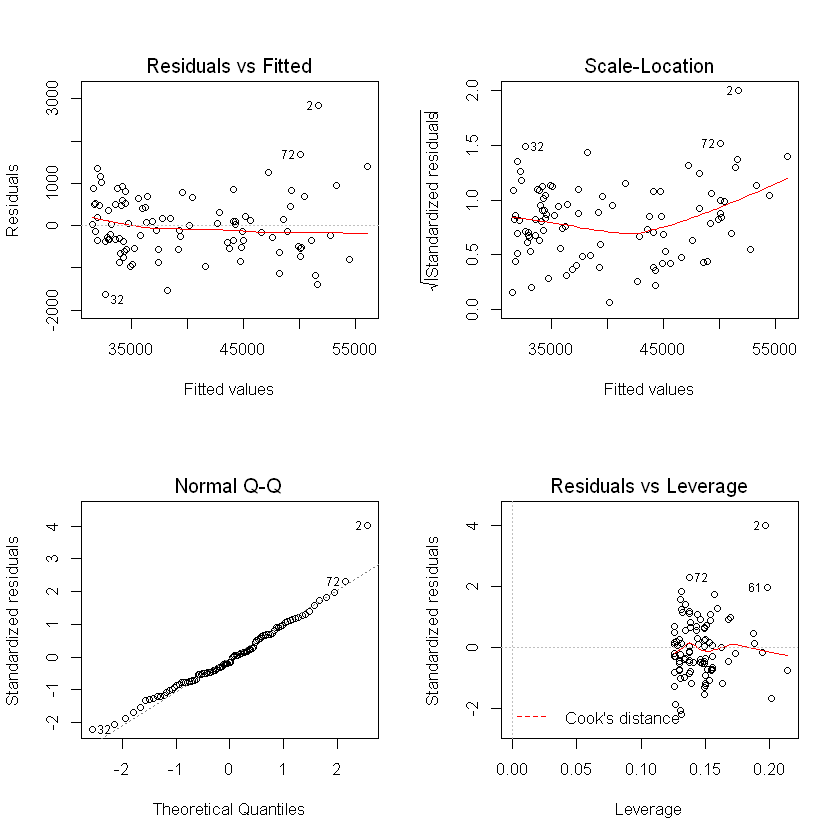

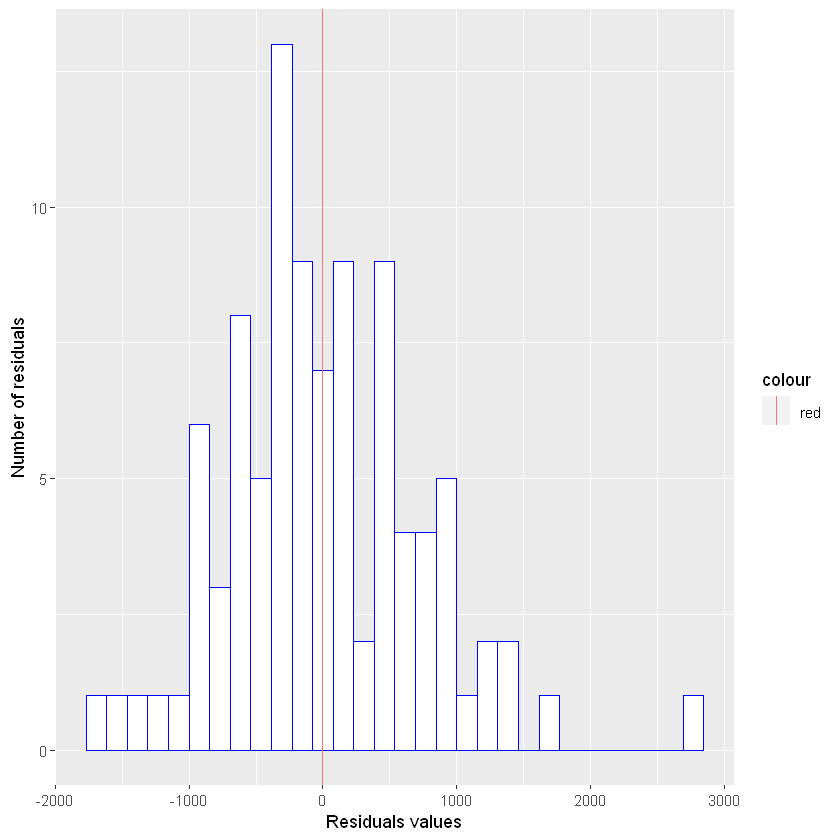

[[1]]
NULL

[[2]]

[[3]]

[[4]]

[[5]]

Call:
lm(formula = Conso ~ time + s1 + s2 + s3 + s4 + s5 + s6 + s7 + 
    s8 + s9 + s10 + s11 + s12 - 1 + DJU, data = conso_lm)

Residuals:
    Min      1Q  Median      3Q     Max 
-1626.9  -521.5  -115.2   488.1  2838.0 

Coefficients:
      Estimate Std. Error t value Pr(>|t|)    
time    -1.493      2.972  -0.502    0.617    
s1   35813.991    906.167  39.523   <2e-16 ***
s2   32735.317    846.452  38.674   <2e-16 ***
s3   33709.936    691.500  48.749   <2e-16 ***
s4   30151.066    523.577  57.587   <2e-16 ***
s5   30399.377    405.760  74.920   <2e-16 ***
s6   31373.101    330.086  95.045   <2e-16 ***
s7   33773.656    318.705 105.971   <2e-16 ***
s8   31112.946    321.857  96.667   <2e-16 ***
s9   30796.635    349.295  88.168   <2e-16 ***
s10  31559.118    458.817  68.784   <2e-16 ***
s11  31957.239    696.362  45.892   <2e-16 ***
s12  34166.294    840.052  40.672   <2e-16 ***
DJU     43.372      2.202  19.699   <2e-16 ***
---
Signif. codes:

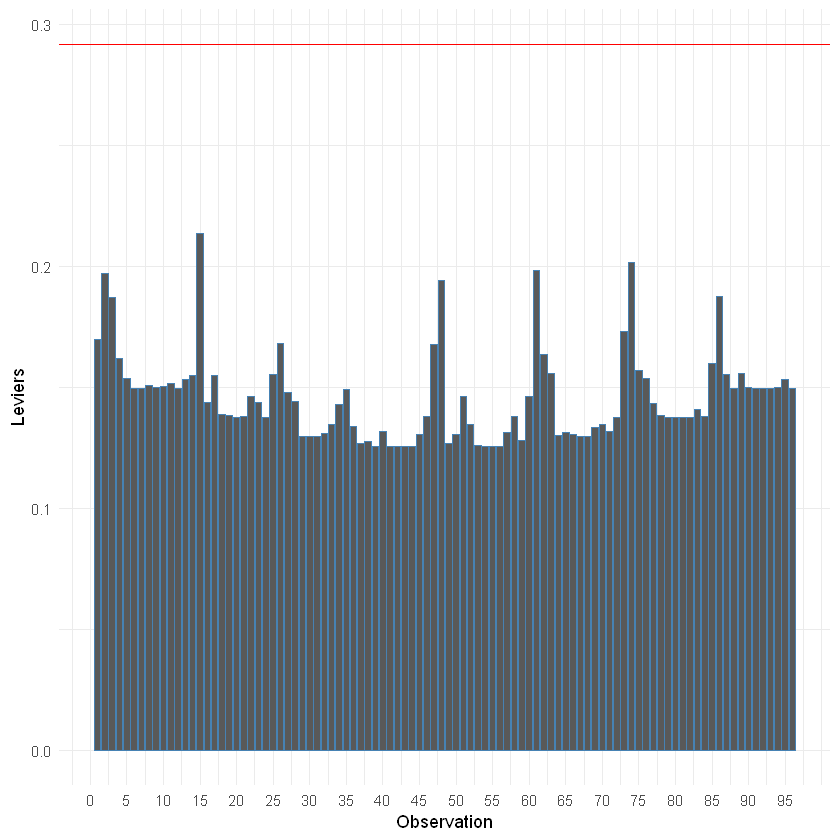

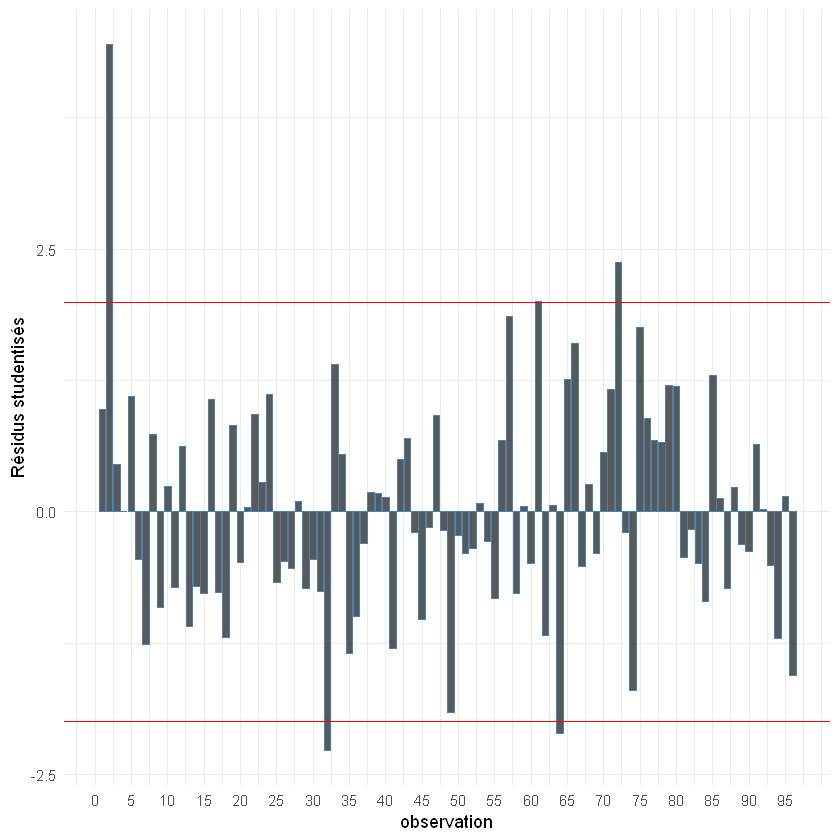

In [6]:
#J'analyse les résidus du modèle
f_graph(fit, 14)

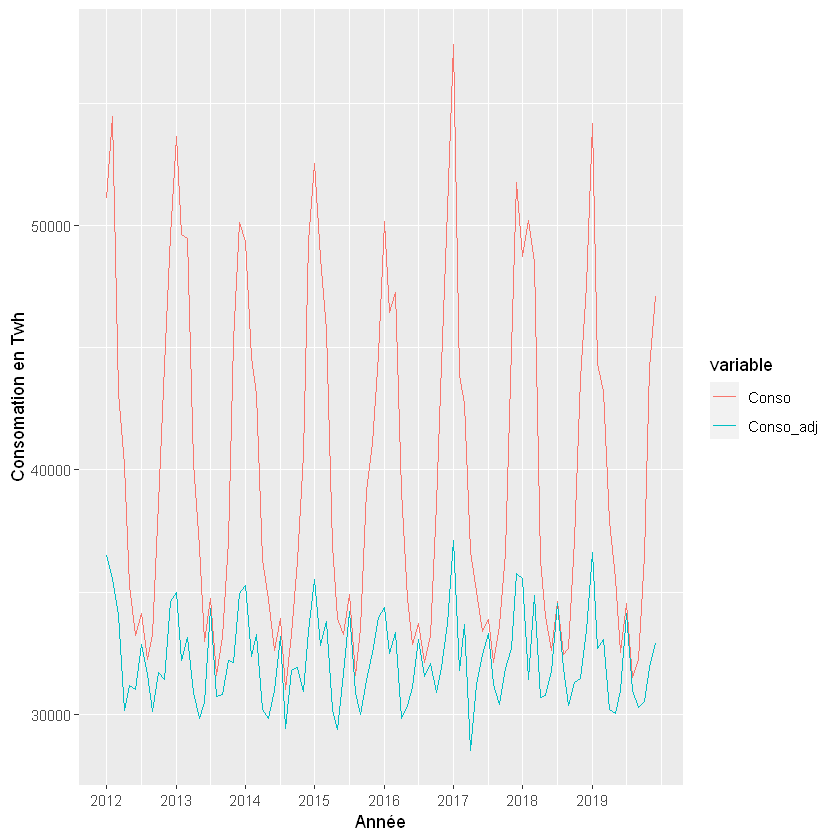

In [7]:
#J'ajoute une colonne qui donne la consomation corrigée de l'effet
#température
conso$Conso_adj<-conso$Conso - conso$DJU*fit$coefficients[["DJU"]]

#Je cré une table pour faire mes graphes où j'ai regroupé les différentes
#données de consomation dans la même colonne
conso_grph<-melt(data = conso, id.vars = c(1:3,5:6), 
                 measure.vars = c(4,7))

#Je construit le graph qui représente la conso en fonction de l'année
#mais aussi la conso corrigé de l'effet température
ggplot(conso_grph, aes(x = time, y = value)) + 
  geom_line(aes(colour = variable))+ 
  scale_x_continuous(breaks=seq(1,96,12),
                   labels = c("2012","2013","2014","2015","2016","2017",
                              "2018","2019"))+ xlab("Année")+
                    ylab("Consomation en Twh")

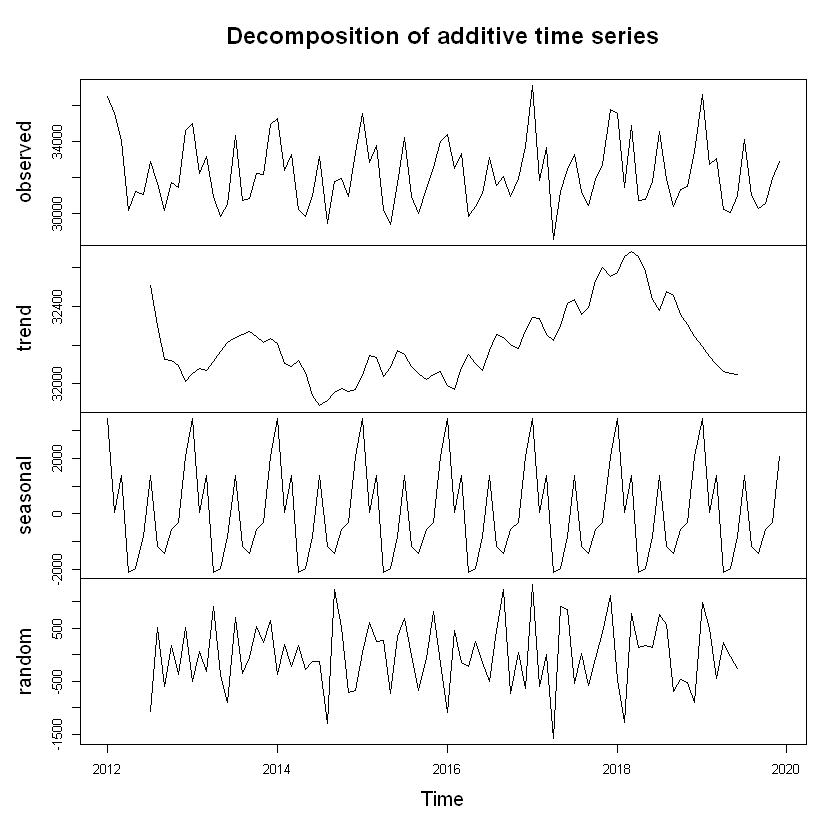

In [8]:
#Je transforme ma colonne conso corrigé effet température au format 
#série temporelle
ts_conso_adj<-ts(conso$Conso_adj, start = c(2012, 1), end = c(2019, 12),
                 frequency = 12)


#J'utilise la fonction decompose pour étudier ma série temporelle
decomp_conso_adj<-decompose(ts_conso_adj)
plot(decomp_conso_adj)

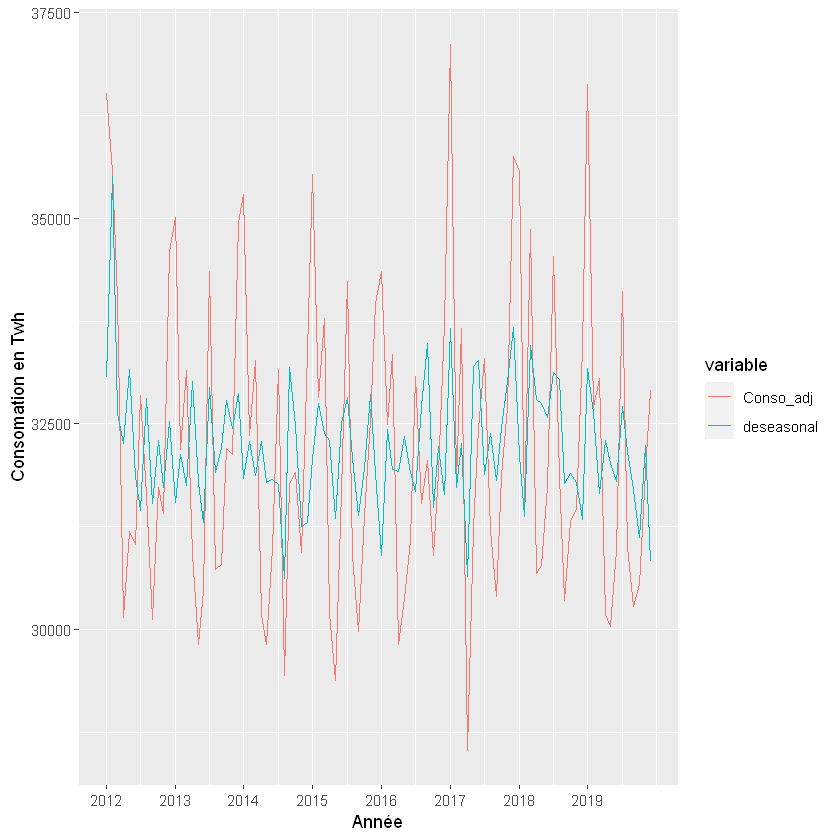

In [9]:
#J'ajoute à ma table principale toutes les parties de ma consomation
#une colonne par partie
conso$trend<-decomp_conso_adj$trend
conso$seasonal<-decomp_conso_adj$seasonal

conso$random<-decomp_conso_adj$random

#Je crée une colonne avec la consomation desaisonalisé
conso$deseasonal<-conso$Conso_adj - conso$seasonal

#Je rejoute les nouvelles données à ma table pour les graphiques
conso_grph<-melt(data = conso, id.vars = c(1:3,5:6), 
                 measure.vars = c(4,7:11))

#Je construit le graph de ma série corrigé de l'effet température
#et de ma série corrigé de l'effet température et désaisonalisé
ggplot(conso_grph%>%filter(variable == "deseasonal" |
                             variable == "Conso_adj"),
       aes(x = time, y = value)) + 
  geom_line(aes(colour = variable))+ 
  scale_x_continuous(breaks=seq(1,96,12),
                   labels = c("2012","2013","2014","2015","2016","2017",
                              "2018","2019"))+ xlab("Année")+
                    ylab("Consomation en Twh") 

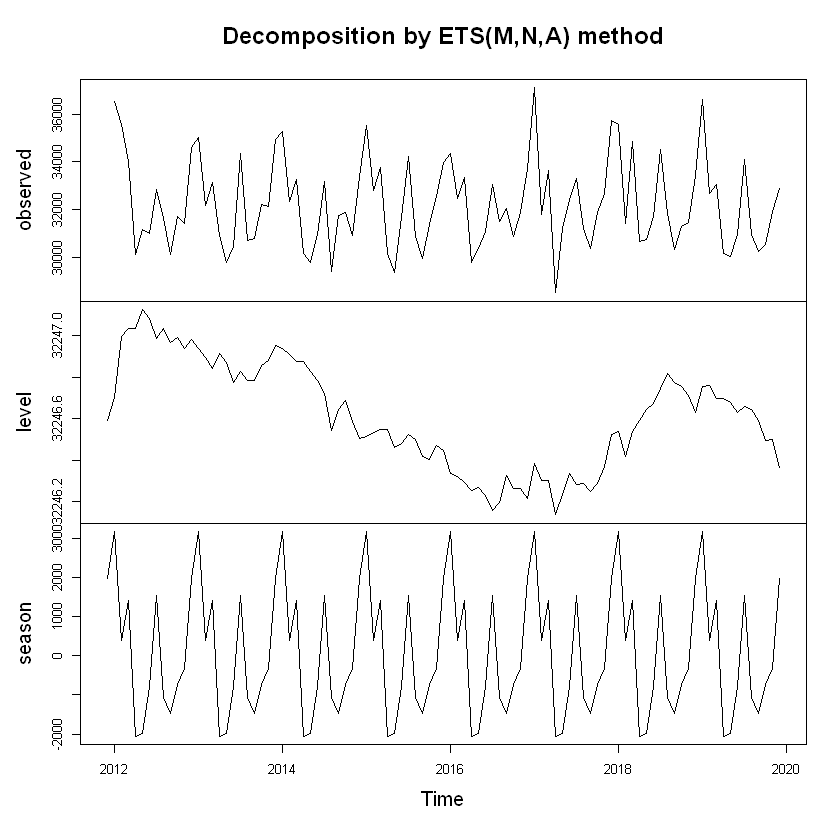

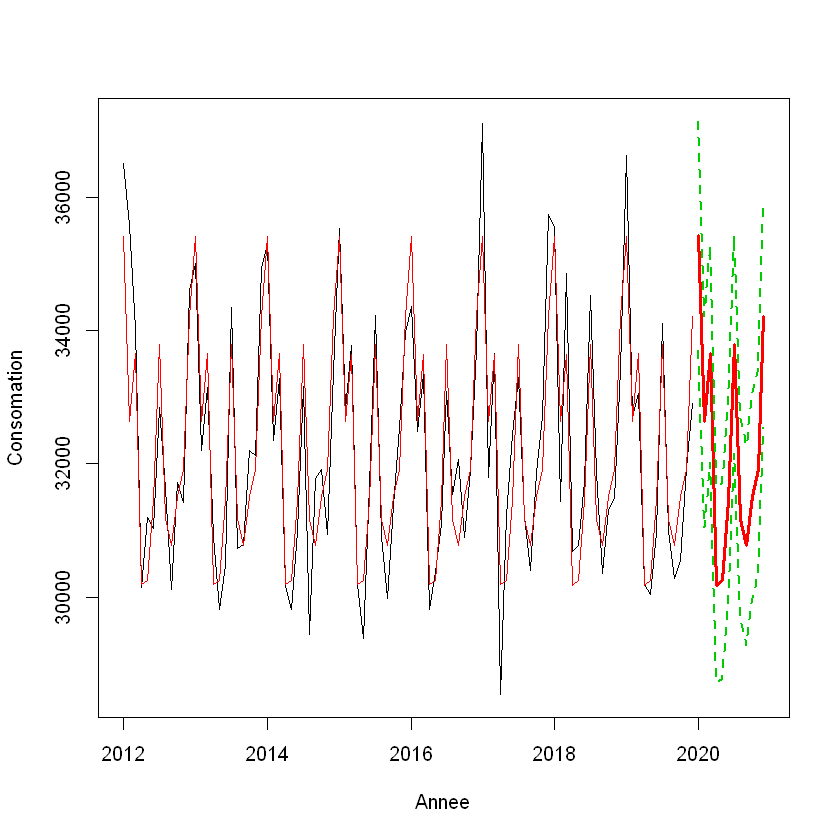

In [10]:
#J'utilise le lissage exponentiel Holt Winter pour effectuer des
#prédictions
hw<-ets(ts_conso_adj, model = "ZZZ")

#J'observe les prédictions
plot(hw)
pred_hw<-predict(hw,12)

#Je cré ensuite le graph de la prédiction sur les années connues puis 
#2 années supplémentaires
ts.plot(pred_hw$x,
        pred_hw$mean,
        pred_hw$lower[,2],
        pred_hw$upper[,2],
        pred_hw$fitted,
        xlab="Annee",ylab="Consomation",
        col=c(1,2,3,3,2),lty=c(1,1,2,2),lwd=c(1,3,2,2))


	Box-Ljung test

data:  pred_hw$residuals
X-squared = 10.932, df = 12, p-value = 0.5347


Retard,p-value
6,0.76714
12,0.62892
18,0.33000
24,0.41346
30,0.32081
36,0.31231



	Shapiro-Wilk normality test

data:  pred_hw$residuals
W = 0.96965, p-value = 0.02514


Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


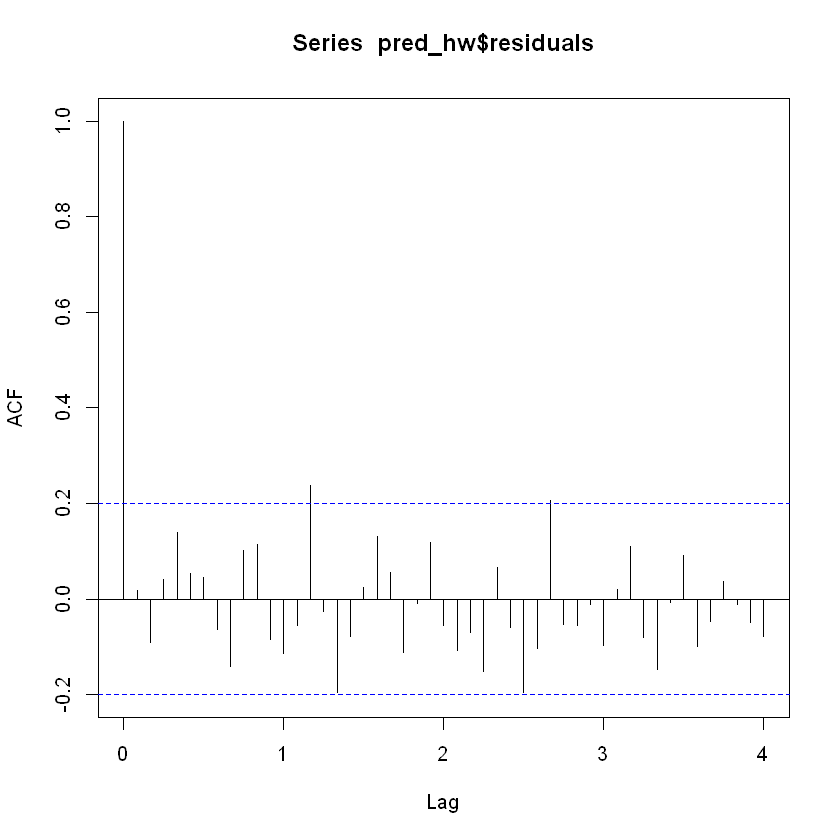

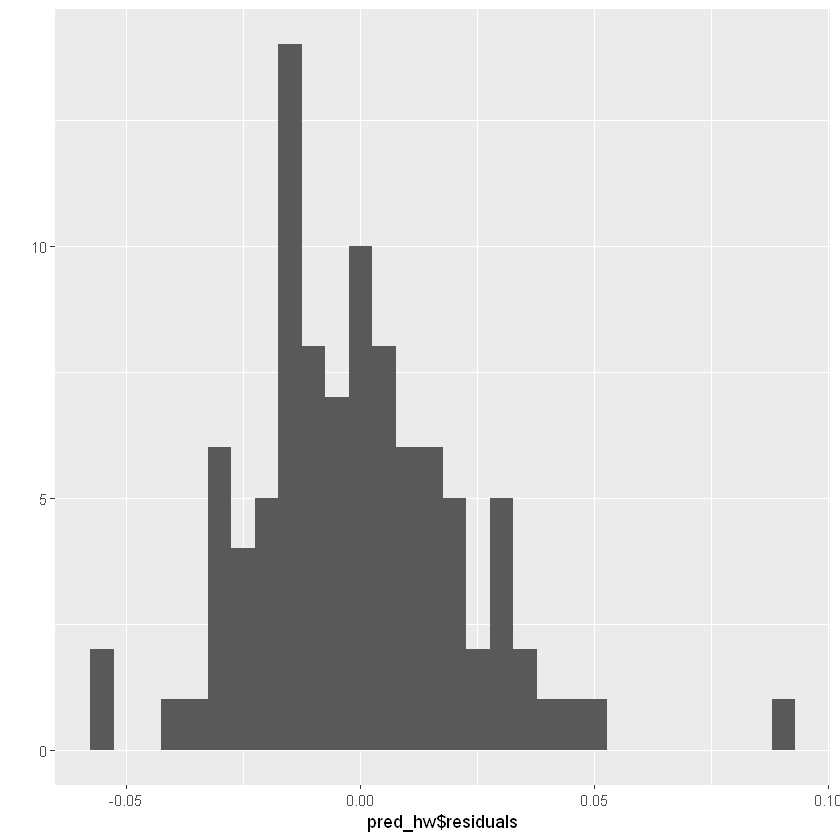

ETS(M,N,A) 

Call:
 ets(y = ts_conso_adj, model = "ZZZ") 

  Smoothing parameters:
    alpha = 1e-04 
    gamma = 0.0023 

  Initial states:
    l = 32246.5919 
    s = 1960.557 -331.9638 -741.9747 -1471.627 -1074.929 1549.063
           -787.3409 -1994.793 -2065.057 1402.805 386.6649 3168.596

  sigma:  0.0248

     AIC     AICc      BIC 
1735.966 1741.966 1774.432 

Training set error measures:
                    ME     RMSE      MAE        MPE     MAPE      MASE
Training set -23.32789 742.9247 574.2253 -0.1325487 1.771785 0.6437558
                   ACF1
Training set 0.02388857


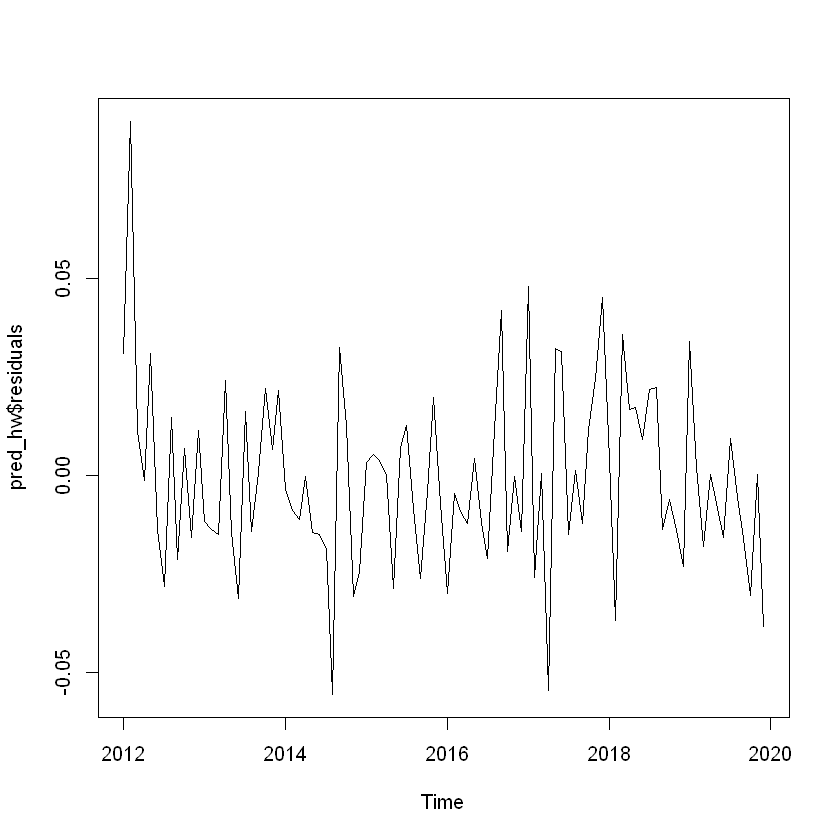

In [11]:
#J'étudie l'autocorrelogram de ma série prédite
acf(pred_hw$residuals, lag.max=48)

#test autocorrélation résidu
Box.test.2(pred_hw$residuals,nlag=c(6,12,18,24,30,36),
           type="Ljung-Box",decim=5)

#test normalité résidus
shapiro.test(pred_hw$residuals)

#graphe normalité des résidus
qplot(pred_hw$residuals)

#J'analyse graphiquement les résidus
plot(pred_hw$residuals)

#J'analyse mon modèle
summary(hw)

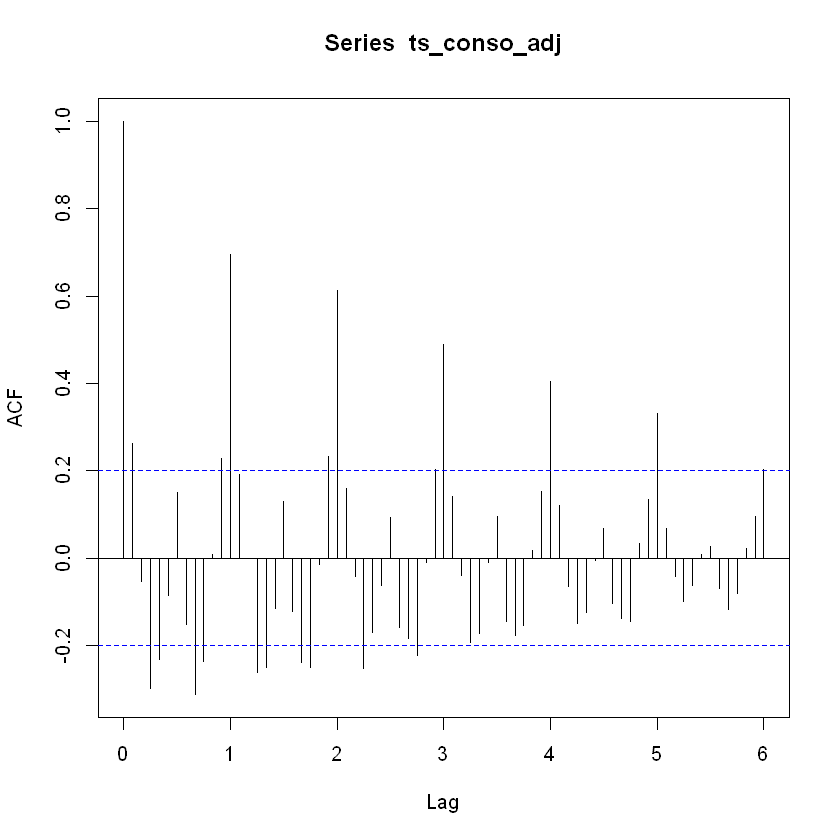

In [12]:
   ###SARIMA#######################################################

#J'utilise maintenant un modèle SARIMA pour effectuer mes prédictions

#J'étudie l'autocorrelogramme de ma série pour étudier comment la série
#doit être différenciée
acf(ts_conso_adj,lag.max=72, plot=TRUE)

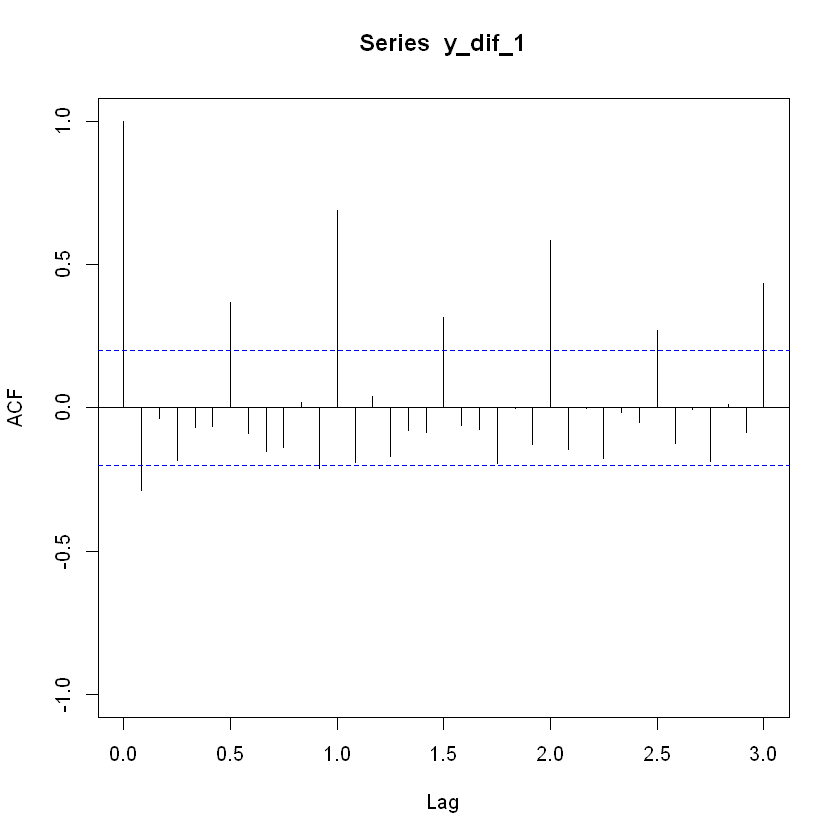

In [13]:
#J'effectue une différenciation de lag 1
y_dif_1=diff(ts_conso_adj,lag=1,differences=1)
#J'analyse l'autoc
plot(acf(y_dif_1,lag.max=36,plot=FALSE),ylim=c(-1,1))

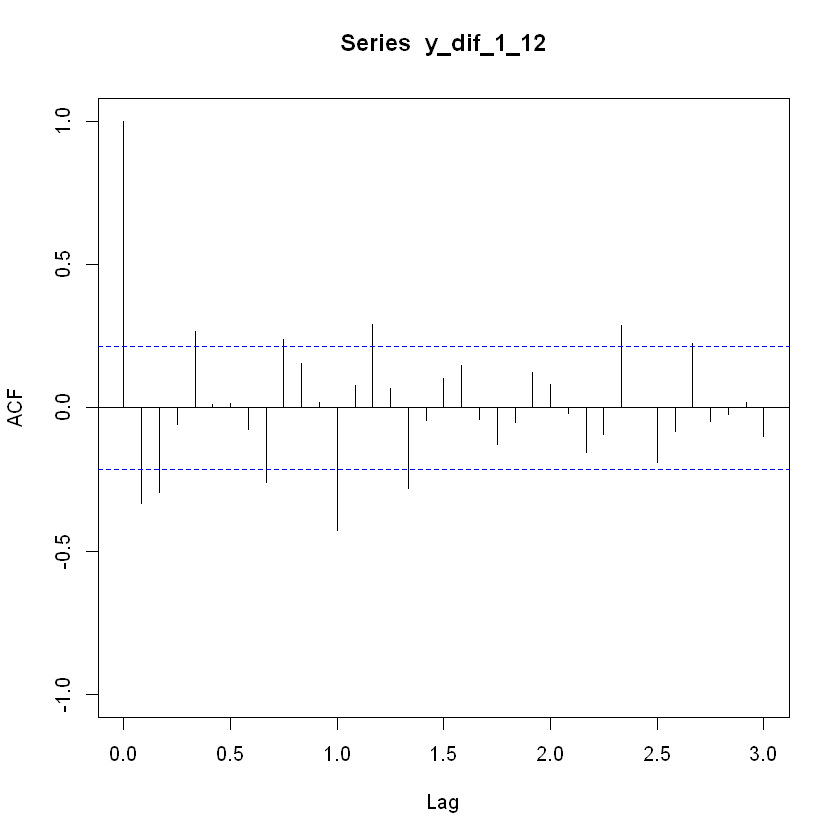

In [14]:
#Je réalise une différenciation de lag 12 en plus de la lag 1
y_dif_1_12=diff(y_dif_1,lag=12, differences = 1)

#J'analyse encore l'autoc pour les coefs AR
plot(acf(y_dif_1_12,lag.max=36,plot=FALSE),ylim=c(-1,1))

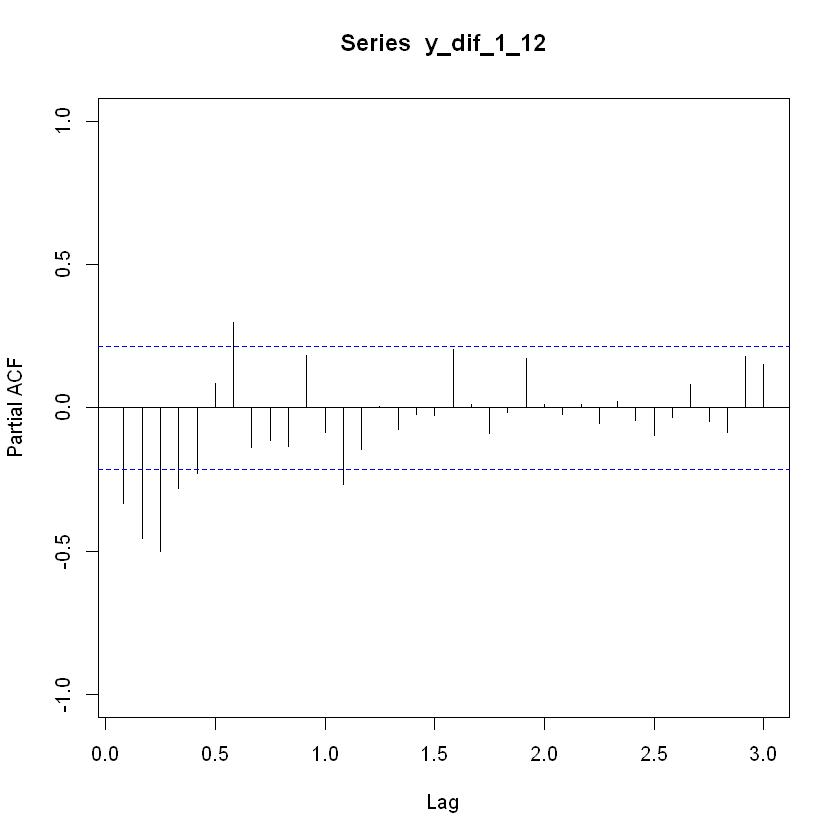

In [15]:
#j'analyse l'autoc partiel pour les coefs MA
plot(pacf(y_dif_1_12,lag.max=36,plot=FALSE),ylim=c(-1,1))

In [16]:
pmax = 5
qmax = 2
Pmax = 0
Qmax = 1
i<-1
c<-data.frame()

for (p in 0:pmax) {
  for (q in 0:qmax) {
    for (p12 in 0:Pmax) {
      for (q12 in 0:Qmax) {
        model1=try(Arima(ts_conso_adj,order=c(p,1,q),
             list(order=c(p12,1,q12),period=12),
             include.mean=TRUE,method="CSS-ML"),TRUE)
        if (class(try(length(t_stat(model1)),TRUE)) == "integer"){
        if (length(t_stat(model1)) == 0){
        c[i,"nom_model"]<-paste("model(",p,"1",q,")(",p12,"1",q12,")",
                                    sep = "")
        c[i,"aic"]<-model1$aic
        c[i,"RMCE"]<-(model1$residuals)^2%>%mean()%>%.^0.5
        i<-i+1
        }
        else if (length(t_stat(model1)[2,]) ==
          try((t_stat(model1)[2,]<0.05)%>%as.numeric()%>%sum())) {
        c[i,"nom_model"]<-paste("model(",p,"1",q,")(",p12,"1",q12,")",
                                    sep = "")
        c[i,"aic"]<-model1$aic
        c[i,"RMCE"]<-(model1$residuals)^2%>%mean()%>%.^0.5
        i<-i+1
        }
        }
      }
    }
  }
}

DT::datatable(c%>%arrange(aic))

HTML widgets cannot be represented in plain text (need html)

Series: ts_conso_adj 
ARIMA(5,1,2)(0,1,1)[12] 

Coefficients:
          ar1      ar2      ar3      ar4      ar5      ma1     ma2     sma1
      -0.7709  -1.5561  -1.1991  -0.8056  -0.4972  -0.1564  0.9606  -0.5394
s.e.   0.1109   0.1079   0.1528   0.1003   0.1095   0.0667  0.0972   0.1425

sigma^2 estimated as 665591:  log likelihood=-675.7
AIC=1369.4   AICc=1371.87   BIC=1391.17

Training set error measures:
                  ME     RMSE      MAE       MPE     MAPE      MASE        ACF1
Training set 65.0033 721.1052 565.5853 0.1714742 1.759606 0.6340696 -0.04743555


,ar1,ar2,ar3,ar4,ar5,ma1,ma2,sma1
t.stat,-6.950599,-14.41578,-7.846014,-8.02871,-4.539019,-2.344428,9.883378,-3.784388
p.val,0.000000,0.00000,0.000000,0.00000,0.000006,0.019056,0.000000,0.000154


Retard,p-value
6,0.99759
12,0.94432
18,0.97548
24,0.99284
30,0.99699
36,0.99809



	Shapiro-Wilk normality test

data:  model1$residuals
W = 0.97991, p-value = 0.1482


Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


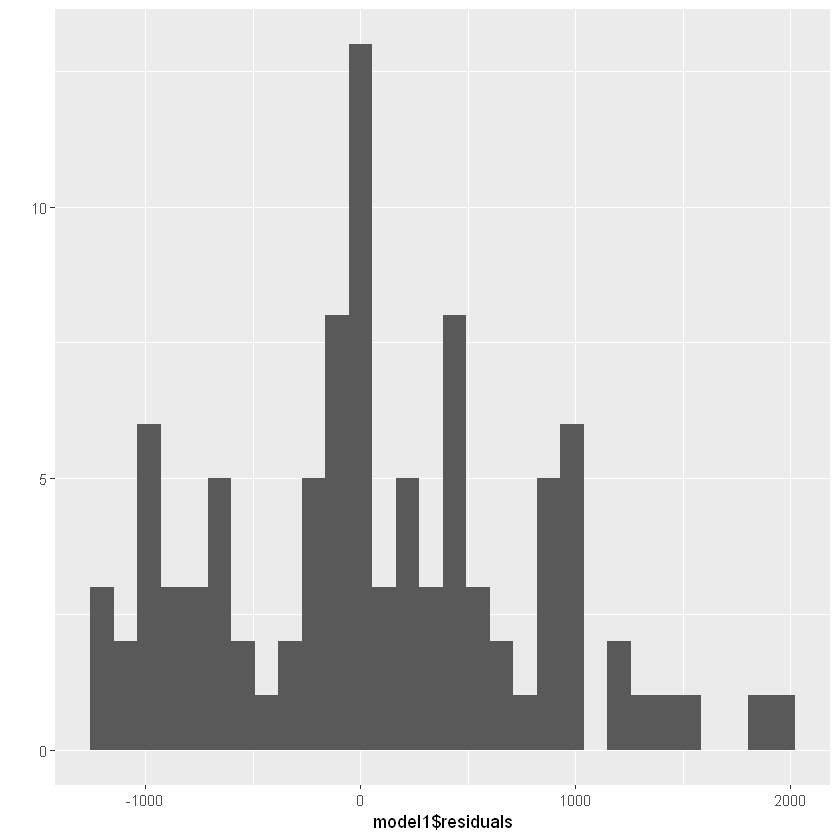

In [17]:
#Je crée le meilleur modèles parmis les modèles testés,
#je l'analyse et le test encore une fois
model1=Arima(ts_conso_adj,order=c(5,1,2),
             list(order=c(0,1,1),period=12),
             include.mean=TRUE,method="CSS-ML")

#analyse
summary(model1)

#tests variables
t_stat(model1)

#test autocorrélation résidu
Box.test.2(model1$residuals,nlag=c(6,12,18,24,30,36),
           type="Ljung-Box",decim=5)

#test normalité résidus
shapiro.test(model1$residuals)

#graphe normalité des résidus
qplot(model1$residuals)

#Je valide le modele

Series: ts_conso_adj 
ARIMA(0,0,0)(0,1,1)[12] 

Coefficients:
         sma1
      -0.8714
s.e.   0.2563

sigma^2 estimated as 689594:  log likelihood=-691.16
AIC=1386.33   AICc=1386.47   BIC=1391.19

Training set error measures:
                    ME     RMSE      MAE        MPE     MAPE      MASE
Training set -82.77066 772.1475 596.4574 -0.2974778 1.852959 0.6686799
                   ACF1
Training set 0.01903371


,sma1
t.stat,-3.400464
p.val,0.000673


Retard,p-value
6,0.77869
12,0.49150
18,0.22727
24,0.34362
30,0.32006
36,0.39712



	Shapiro-Wilk normality test

data:  model2$residuals
W = 0.98952, p-value = 0.6535


Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


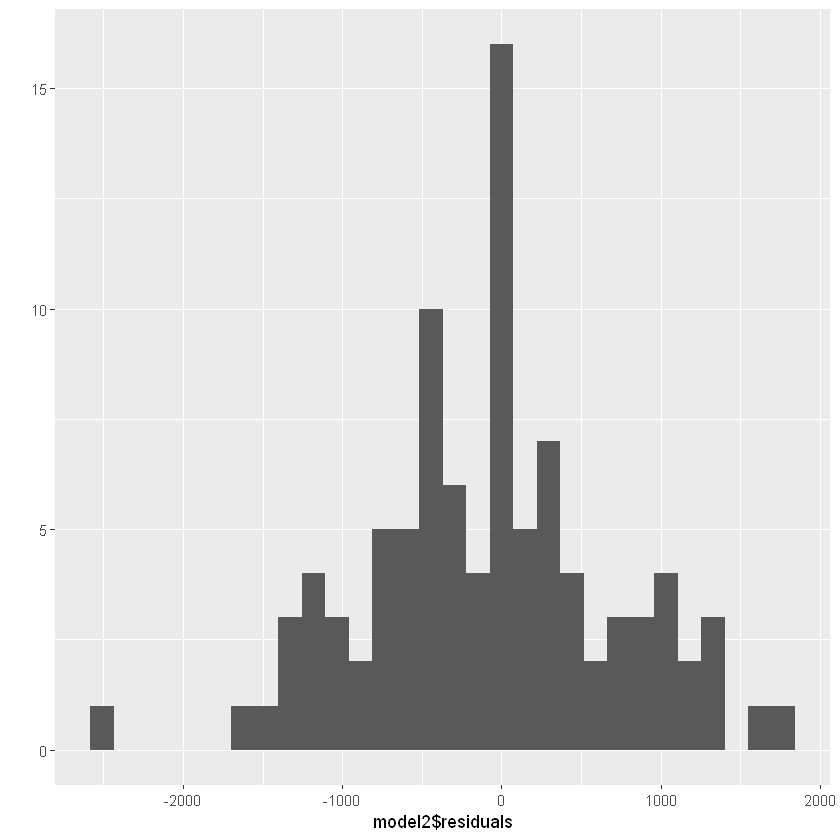

In [18]:
#J'utilise une fonction qui permet de trouver des modèles performants
#de façon automatique
model2<-auto.arima(ts_conso_adj)

#c'est le modèle (000)(011) qui est trouvé par la fonction

#J'analyse et test le modèle
summary(model2)

t_stat(model2)

Box.test.2(model2$residuals,nlag=c(6,12,18,24,30,36),
           type="Ljung-Box",decim=5)

shapiro.test(model2$residuals)

qplot(model2$residuals)

#le model1 est plus performant je le conserve

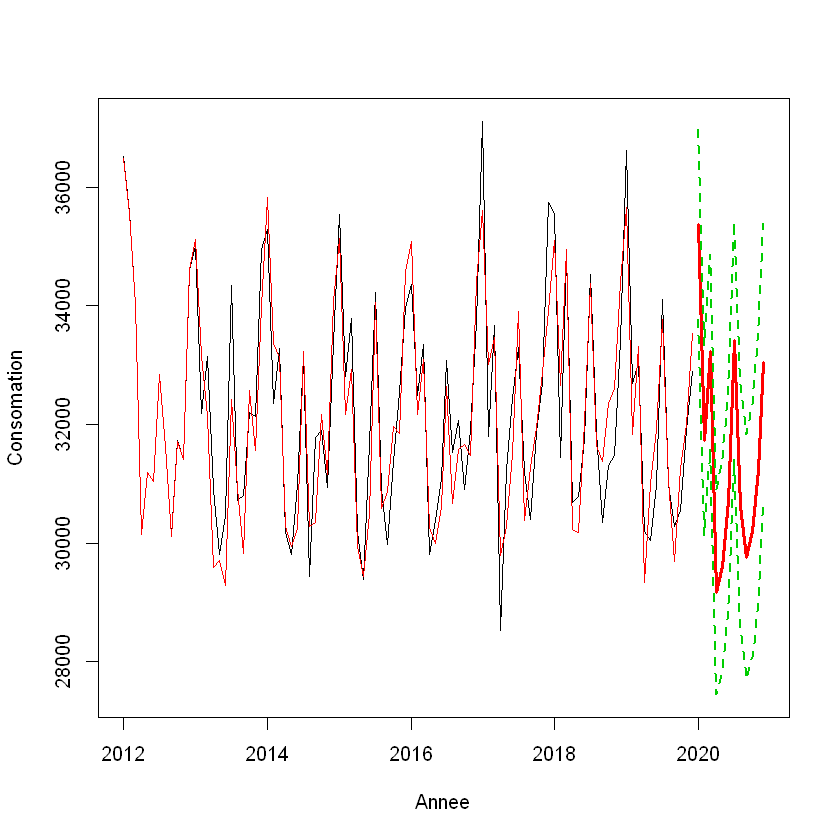

In [19]:
#J'effectue une prédiction avec le modèle choisi
pred_model1=forecast(model1,h=12,level=95)

#Je cré ensuite le graph de la prédiction sur les années connues puis 
#1 année supplémentaires
ts.plot(pred_model1$x,
        pred_model1$mean,
        pred_model1$lower,
        pred_model1$upper,
        pred_model1$fitted,
        xlab="Annee",ylab="Consomation",
        col=c(1,2,3,3,2),lty=c(1,1,2,2),lwd=c(1,3,2,2))

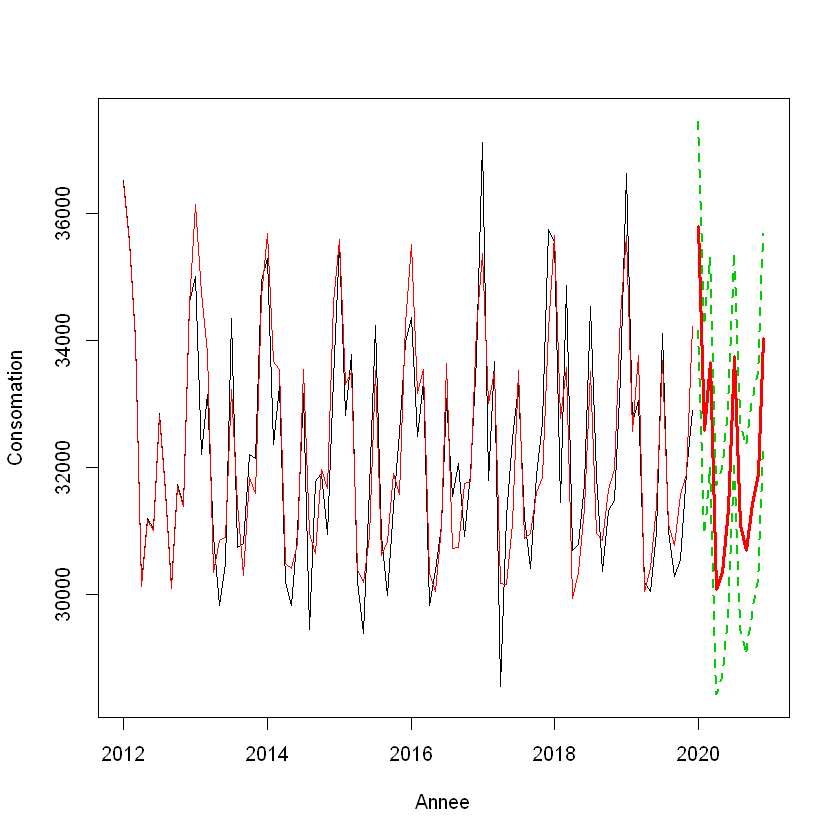

In [20]:
#J'effectue une prédiction avec le modèle trouvé automatiquement
pred_model2=forecast(model2,h=12,level=95)

#Je cré ensuite le graph de la prédiction sur les années connues puis 
#1 année supplémentaires
ts.plot(pred_model2$x,
        pred_model2$mean,
        pred_model2$lower,
        pred_model2$upper,
        pred_model2$fitted,
        xlab="Annee",ylab="Consomation",
        col=c(1,2,3,3,2),lty=c(1,1,2,2),lwd=c(1,3,2,2))